# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
import pandas as pd
import numpy as np


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=True)


Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


# Methods


In [5]:
def add_info(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # Define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban_settlement_ssb']):
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [6]:
def plot_compliance_rate(dataframe: pd.DataFrame, urban: bool = True, limit_left: str = None, limit_right: str = None):
    # extract date from time_call_received
    dataframe['date'] = dataframe['time_call_received'].dt.date
    
    # group by date and calculate compliance rate
    compliance_rate = dataframe[dataframe["urban_settlement_ssb"] == urban].groupby('date')['complied'].mean()  # mean of boolean is the rate of True values
    
    # plot data
    matplotlib.pyplot.figure(figsize=(12, 6))
    matplotlib.pyplot.plot(compliance_rate.index, compliance_rate.values)

    # aesthetics
    if limit_left is not None:
        matplotlib.pyplot.xlim(left=pd.Timestamp(limit_left))
    if limit_right is not None:
        matplotlib.pyplot.xlim(right=pd.Timestamp(limit_right))

    matplotlib.pyplot.gca().xaxis.set_major_locator(matplotlib.dates.YearLocator())
    matplotlib.pyplot.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

    matplotlib.pyplot.grid(True)

    # set labels
    matplotlib.pyplot.title(f"Compliance Rate For {'Urban' if urban else 'Non-urban'} Incidents Per Day Over Years", fontdict=constants.FONT_PROPERTIES_SUB_HEADER)

    matplotlib.pyplot.xlabel("Year")
    matplotlib.pyplot.ylabel("Compliance Rate")

    # save/show plot
    matplotlib.pyplot.show()


In [7]:
def analyze_response_by_date(dataframe: pd.DataFrame, specific_date: str):
    # Convert specific_date to datetime object to ensure matching
    specific_date_dt = pd.to_datetime(specific_date).date()
    
    # Filter dataframe for the given date
    dataframe['date'] = dataframe['time_call_received'].dt.date  # Ensure time_call_received is datetime type
    date_filtered_df = dataframe[dataframe['date'] == specific_date_dt]
    
    if date_filtered_df.empty:
        print("No data available for the specified date.")
        return None
    
    # Group by urban_settlement_ssb and triage_impression_during_call
    grouped = date_filtered_df.groupby(['urban_settlement_ssb', 'triage_impression_during_call'])
    
    # Calculate mean and median response times
    response_stats = grouped['total_response_time'].agg(['mean', 'median']).reset_index()
    
    # Calculate compliance rate, ignore NaN values naturally
    compliance_rate = grouped['complied'].mean().reset_index()
    compliance_rate.columns = ['urban_settlement_ssb', 'triage_impression_during_call', 'compliance_rate']

    # Merge stats and compliance rate into a single DataFrame for better readability
    result = pd.merge(response_stats, compliance_rate, on=['urban_settlement_ssb', 'triage_impression_during_call'], how='outer')
    
    # Handling NaN values in compliance_rate by filling them with a default or a note
    result['compliance_rate'] = result['compliance_rate'].apply(lambda x: np.round(x * 100, 2) if pd.notna(x) else "")
    # Formatting the output for better readability
    result['mean'] = (result['mean'] / 60).round(2)  # Use numpy's round function for robustness
    result['median'] = (result['median'] / 60).round(2)
    
    return result


In [8]:
def find_best_and_worst_compliance_days(dataframe: pd.DataFrame):
    # Ensure the time_call_received is in datetime format
    if dataframe['time_call_received'].dtype != 'datetime64[ns]':
        dataframe['time_call_received'] = pd.to_datetime(dataframe['time_call_received'])
    
    # Filter the dataframe for the year 2018
    dataframe['year'] = dataframe['time_call_received'].dt.year
    year_filtered_df = dataframe[dataframe['year'] == 2018]
    
    if year_filtered_df.empty:
        print("No data available for the year 2018.")
        return None
    
    # Extract date from time_call_received
    year_filtered_df['date'] = year_filtered_df['time_call_received'].dt.date
    
    # Group by date and calculate the mean compliance rate for each day
    daily_compliance = year_filtered_df.groupby('date')['complied'].mean()
    
    # Find the best and worst days
    best_day = daily_compliance.idxmax()
    worst_day = daily_compliance.idxmin()
    best_day_rate = daily_compliance.max()
    worst_day_rate = daily_compliance.min()
    
    # Return results in a clear format
    results = {
        'Best Day': best_day,
        'Best Day Compliance Rate': best_day_rate,
        'Worst Day': worst_day,
        'Worst Day Compliance Rate': worst_day_rate
    }
    
    return results


# Main

In [9]:
dataframe = data_loader.enhanced_incidents_df.copy(deep=True)
dataframe = add_info(dataframe)


C:\Users\sindr\AppData\Local\Temp\ipykernel_11340\1518890614.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


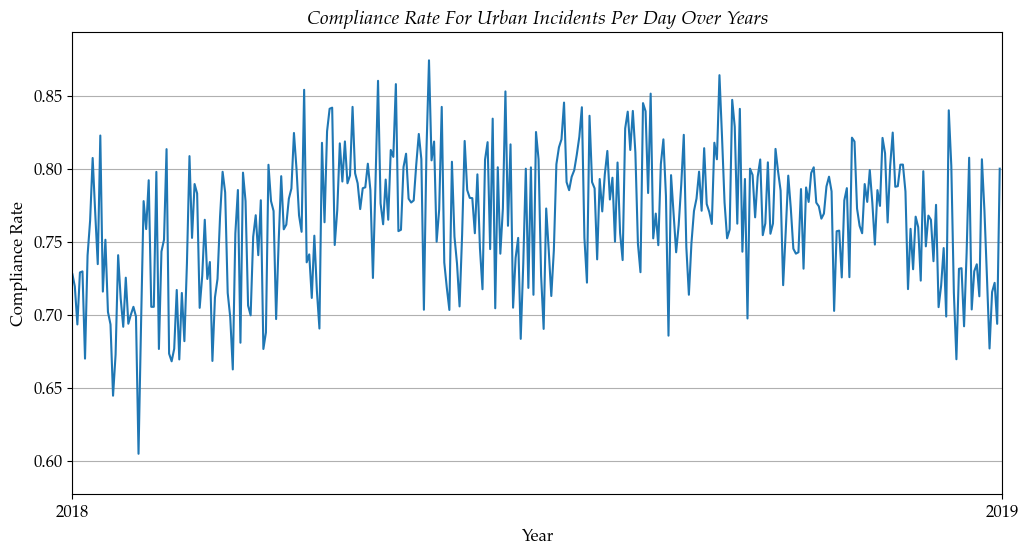

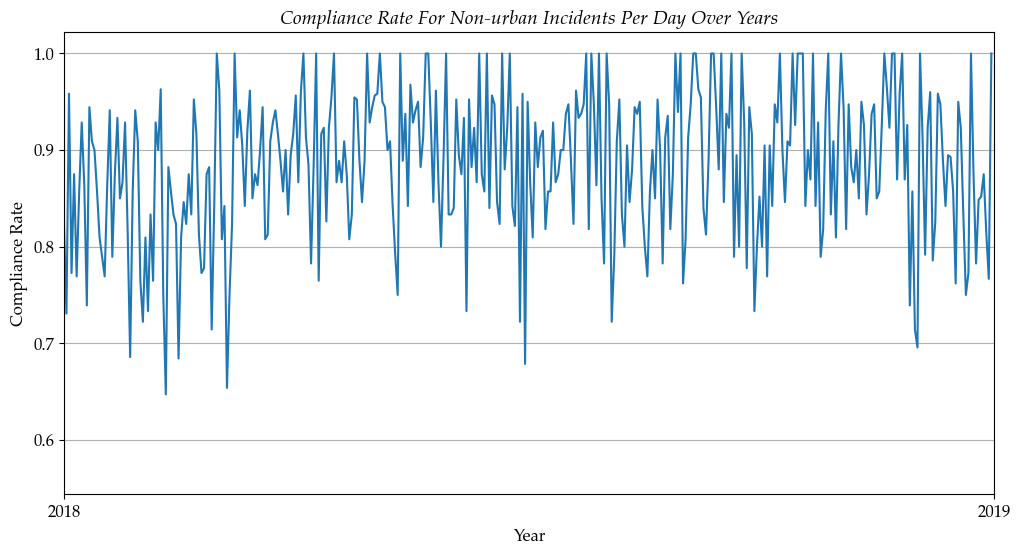

In [10]:
plot_compliance_rate(dataframe, urban=True, limit_left="2018-01-01", limit_right="2019-01-01")
plot_compliance_rate(dataframe, urban=False, limit_left="2018-01-01", limit_right="2019-01-01")


In [11]:
analyze_response_by_date(dataframe, specific_date="2018-04-10")


,urban_settlement_ssb,triage_impression_during_call,mean,median,compliance_rate
0,False,A,12.45,12.62,100.0
1,False,H,17.07,15.61,100.0
2,False,V1,77.11,91.12,
3,True,A,9.26,8.20,78.49
4,True,H,23.45,17.92,74.56
5,True,V1,64.66,54.57,


In [12]:
find_best_and_worst_compliance_days(dataframe)


C:\Users\sindr\AppData\Local\Temp\ipykernel_11340\2641114372.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_filtered_df['date'] = year_filtered_df['time_call_received'].dt.date


{'Best Day': datetime.date(2018, 9, 12),
 'Best Day Compliance Rate': 0.8793103448275862,
 'Worst Day': datetime.date(2018, 1, 27),
 'Worst Day Compliance Rate': 0.616}